In [1]:
spark

In [2]:
from google.cloud import storage

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct, column, isnan, when, count, col

In [3]:
bucket_name = 'ppp-loan-analysis'
gs_path  = f'gs://{bucket_name}/'
raw_folder = 'raw-data/'
clean_folder = 'clean-data/'
final_folder = 'final-data/'
dropped_folder = 'dropped-data/'
ppp_folder = 'ppp-data/'

In [4]:
spark = SparkSession.builder.appName('ppp_eda').getOrCreate()

25/10/08 20:58:36 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
storage_client = storage.Client() 
bucket = storage_client.get_bucket(bucket_name)

# Raw PPP Data

In [7]:
raw_ppp_files_path = gs_path + raw_folder + ppp_folder + '*.csv'
raw_ppp_df = spark.read.csv(raw_ppp_files_path, header=True, inferSchema=True)
raw_ppp_df.cache()

25/09/24 21:05:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[LoanNumber: bigint, DateApproved: string, SBAOfficeCode: double, ProcessingMethod: string, BorrowerName: string, BorrowerAddress: string, BorrowerCity: string, BorrowerState: string, BorrowerZip: string, LoanStatusDate: string, LoanStatus: string, Term: string, SBAGuarantyPercentage: string, InitialApprovalAmount: string, CurrentApprovalAmount: string, UndisbursedAmount: string, FranchiseName: string, ServicingLenderLocationID: string, ServicingLenderName: string, ServicingLenderAddress: string, ServicingLenderCity: string, ServicingLenderState: string, ServicingLenderZip: string, RuralUrbanIndicator: string, HubzoneIndicator: string, LMIIndicator: string, BusinessAgeDescription: string, ProjectCity: string, ProjectCountyName: string, ProjectState: string, ProjectZip: string, CD: string, JobsReported: string, NAICSCode: string, Race: string, Ethnicity: string, UTILITIES_PROCEED: string, PAYROLL_PROCEED: string, MORTGAGE_INTEREST_PROCEED: double, RENT_PROCEED: double, REFINANC

In [8]:
# Raw PPP DataFrame Schema
raw_ppp_df.printSchema()

root
 |-- LoanNumber: long (nullable = true)
 |-- DateApproved: string (nullable = true)
 |-- SBAOfficeCode: double (nullable = true)
 |-- ProcessingMethod: string (nullable = true)
 |-- BorrowerName: string (nullable = true)
 |-- BorrowerAddress: string (nullable = true)
 |-- BorrowerCity: string (nullable = true)
 |-- BorrowerState: string (nullable = true)
 |-- BorrowerZip: string (nullable = true)
 |-- LoanStatusDate: string (nullable = true)
 |-- LoanStatus: string (nullable = true)
 |-- Term: string (nullable = true)
 |-- SBAGuarantyPercentage: string (nullable = true)
 |-- InitialApprovalAmount: string (nullable = true)
 |-- CurrentApprovalAmount: string (nullable = true)
 |-- UndisbursedAmount: string (nullable = true)
 |-- FranchiseName: string (nullable = true)
 |-- ServicingLenderLocationID: string (nullable = true)
 |-- ServicingLenderName: string (nullable = true)
 |-- ServicingLenderAddress: string (nullable = true)
 |-- ServicingLenderCity: string (nullable = true)
 |-- 

In [9]:
# Number of columns and rows in Raw PPP DataFrame
print(f"Number of columns: {len(raw_ppp_df.columns)}")
print(f"Number of rows: {raw_ppp_df.count()}")

Number of columns: 53


Number of rows: 11468210


In [9]:
# Size of the entire dataframe
print(f"Size of the entire dataframe in bytes: {raw_ppp_df.rdd.map(lambda row: len(str(row))).sum()}")

Size of the entire dataframe in bytes: 17061882659


In [11]:
# Number of unique values in each column of the dataframe
unique_counts = raw_ppp_df.agg(*(countDistinct(column(c)).alias(c) for c in raw_ppp_df.columns))
unique_counts.show()

+----------+------------+-------------+----------------+------------+---------------+------------+-------------+-----------+--------------+----------+----+---------------------+---------------------+---------------------+-----------------+-------------+-------------------------+-------------------+----------------------+-------------------+--------------------+------------------+-------------------+----------------+------------+----------------------+-----------+-----------------+------------+----------+---+------------+---------+----+---------+-----------------+---------------+-------------------------+------------+----------------------+-------------------+---------------------+------------+---------------------------+-----------------+---------------------+----------------------+------+-------+---------+-----------------+---------------+
|LoanNumber|DateApproved|SBAOfficeCode|ProcessingMethod|BorrowerName|BorrowerAddress|BorrowerCity|BorrowerState|BorrowerZip|LoanStatusDate|LoanStat

In [14]:
null_nan_counts = raw_ppp_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in raw_ppp_df.columns])
null_nan_counts.show()

+----------+------------+-------------+----------------+------------+---------------+------------+-------------+-----------+--------------+----------+----+---------------------+---------------------+---------------------+-----------------+-------------+-------------------------+-------------------+----------------------+-------------------+--------------------+------------------+-------------------+----------------+------------+----------------------+-----------+-----------------+------------+----------+---+------------+---------+----+---------+-----------------+---------------+-------------------------+------------+----------------------+-------------------+---------------------+------------+---------------------------+-----------------+---------------------+----------------------+------+-------+---------+-----------------+---------------+
|LoanNumber|DateApproved|SBAOfficeCode|ProcessingMethod|BorrowerName|BorrowerAddress|BorrowerCity|BorrowerState|BorrowerZip|LoanStatusDate|LoanStat

In [15]:
# Set InitialApprovalAmount, CurrentApprovalAmount, and UndisbursedAmount to double
raw_ppp_df = raw_ppp_df.withColumn("InitialApprovalAmount", raw_ppp_df["InitialApprovalAmount"].cast("double")) \
                       .withColumn("CurrentApprovalAmount", raw_ppp_df["CurrentApprovalAmount"].cast("double")) \
                       .withColumn("UndisbursedAmount", raw_ppp_df["UndisbursedAmount"].cast("double"))

# Summary statistics for InitialApprovalAmount, CurrentApprovalAmount, and UndisbursedAmount
raw_ppp_df.select("InitialApprovalAmount", "CurrentApprovalAmount", "UndisbursedAmount").describe().show()

+-------+---------------------+---------------------+------------------+
|summary|InitialApprovalAmount|CurrentApprovalAmount| UndisbursedAmount|
+-------+---------------------+---------------------+------------------+
|  count|             11468209|             11468209|          11467066|
|   mean|    69481.26948668293|    69112.88843467546|0.2916425212866133|
| stddev|   260366.70654722565|   257656.11950719336|293.81883760601664|
|    min|            -199659.0|                  0.0|               0.0|
|    max|                1.0E7|                1.0E7|         612491.45|
+-------+---------------------+---------------------+------------------+



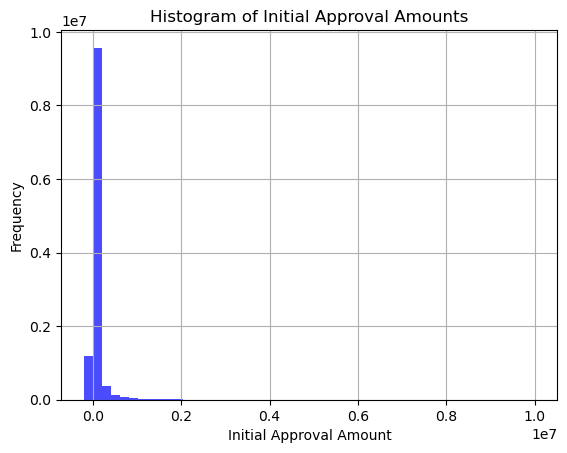

In [17]:
# Create a histogram for InitialApprovalAmount
import matplotlib.pyplot as plt
import numpy as np
initial_approval_amounts = raw_ppp_df.filter(raw_ppp_df["InitialApprovalAmount"].isNotNull()).select("InitialApprovalAmount").rdd.flatMap(lambda x: x).collect()
plt.hist(initial_approval_amounts, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Initial Approval Amounts')
plt.xlabel('Initial Approval Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

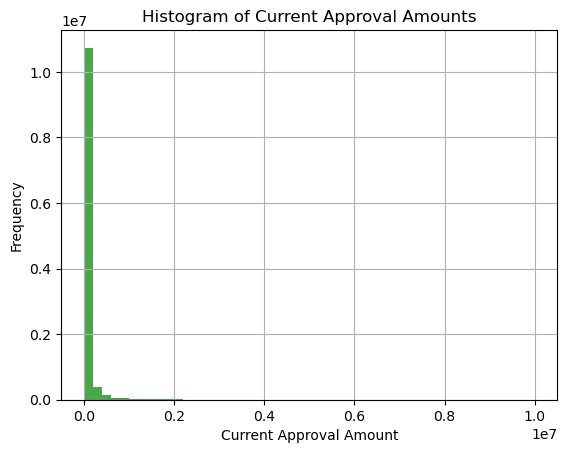

In [18]:
# Histogram for CurrentApprovalAmount
current_approval_amounts = raw_ppp_df.filter(raw_ppp_df["CurrentApprovalAmount"].isNotNull()).select("CurrentApprovalAmount").rdd.flatMap(lambda x: x).collect()
plt.hist(current_approval_amounts, bins=50, color='green', alpha=0.7)
plt.title('Histogram of Current Approval Amounts')
plt.xlabel('Current Approval Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

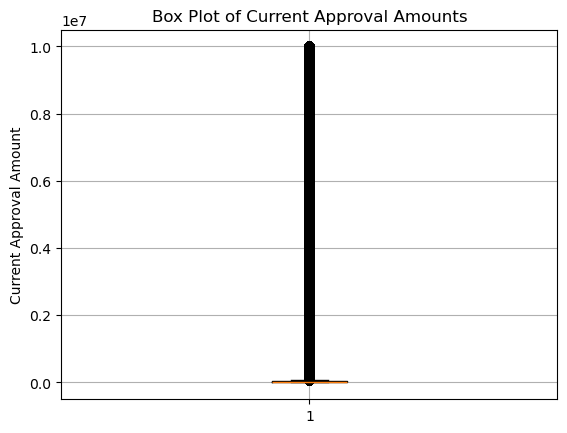

In [20]:
# Box plot for CurrentApprovalAmount
plt.boxplot(current_approval_amounts, vert=True)
plt.title('Box Plot of Current Approval Amounts')
plt.ylabel('Current Approval Amount')
plt.grid(True)
plt.show()

# Clean PPP Data

In [6]:
clean_ppp_files_path = gs_path + clean_folder + ppp_folder + '*.csv'
clean_ppp_df = spark.read.csv(clean_ppp_files_path, header=True, inferSchema=True)
clean_ppp_df.cache()

25/09/25 17:42:52 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[loan_number: bigint, date_approved_id: int, sba_office_code: int, processing_method: string, borrower_name: string, borrower_address: string, borrower_city: string, borrower_state: string, borrower_zip: string, loan_status_date_id: string, loan_status: string, term_month: string, sba_guaranty_percentage: string, initial_approval_amount: double, current_approval_amount: double, undisbursed_amount: double, franchise_name: string, servicing_lender_location_id: double, servicing_lender_name: string, servicing_lender_address: string, servicing_lender_city: string, servicing_lender_state: string, servicing_lender_zip: string, business_age_description: string, project_county_name: string, project_state: string, jobs_reported: string, naics_code: string, race: string, ethnicity: string, business_type: string, originating_lender_location_id: string, originating_lender: string, originating_lender_city: string, originating_lender_state: string, gender: string, veteran: string, nonprofit

In [7]:
# Clean PPP DataFrame Schema
clean_ppp_df.printSchema()

root
 |-- loan_number: long (nullable = true)
 |-- date_approved_id: integer (nullable = true)
 |-- sba_office_code: integer (nullable = true)
 |-- processing_method: string (nullable = true)
 |-- borrower_name: string (nullable = true)
 |-- borrower_address: string (nullable = true)
 |-- borrower_city: string (nullable = true)
 |-- borrower_state: string (nullable = true)
 |-- borrower_zip: string (nullable = true)
 |-- loan_status_date_id: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- term_month: string (nullable = true)
 |-- sba_guaranty_percentage: string (nullable = true)
 |-- initial_approval_amount: double (nullable = true)
 |-- current_approval_amount: double (nullable = true)
 |-- undisbursed_amount: double (nullable = true)
 |-- franchise_name: string (nullable = true)
 |-- servicing_lender_location_id: double (nullable = true)
 |-- servicing_lender_name: string (nullable = true)
 |-- servicing_lender_address: string (nullable = true)
 |-- servicing

In [8]:
# Number of columns and rows in Clean PPP DataFrame
print(f"Number of columns: {len(clean_ppp_df.columns)}")
print(f"Number of rows: {clean_ppp_df.count()}")

Number of columns: 41


Number of rows: 9936143


In [9]:
# Size of the entire dataframe
print(f"Size of the entire dataframe in bytes: {clean_ppp_df.rdd.map(lambda row: len(str(row))).sum()}")

Size of the entire dataframe in bytes: 12467934945


In [10]:
# Number of unique values in each column of the dataframe
unique_counts = clean_ppp_df.agg(*(countDistinct(column(c)).alias(c) for c in clean_ppp_df.columns))
unique_counts.show()

+-----------+----------------+---------------+-----------------+-------------+----------------+-------------+--------------+------------+-------------------+-----------+----------+-----------------------+-----------------------+-----------------------+------------------+--------------+----------------------------+---------------------+------------------------+---------------------+----------------------+--------------------+------------------------+-------------------+-------------+-------------+----------+----+---------+-------------+------------------------------+------------------+-----------------------+------------------------+------+-------+---------+------------------+-------------------+------------+
|loan_number|date_approved_id|sba_office_code|processing_method|borrower_name|borrower_address|borrower_city|borrower_state|borrower_zip|loan_status_date_id|loan_status|term_month|sba_guaranty_percentage|initial_approval_amount|current_approval_amount|undisbursed_amount|franchise_n

In [11]:
# Number of null and NaN values in each column of the dataframe
null_nan_counts = clean_ppp_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in clean_ppp_df.columns])
null_nan_counts.show()

+-----------+----------------+---------------+-----------------+-------------+----------------+-------------+--------------+------------+-------------------+-----------+----------+-----------------------+-----------------------+-----------------------+------------------+--------------+----------------------------+---------------------+------------------------+---------------------+----------------------+--------------------+------------------------+-------------------+-------------+-------------+----------+----+---------+-------------+------------------------------+------------------+-----------------------+------------------------+------+-------+---------+------------------+-------------------+------------+
|loan_number|date_approved_id|sba_office_code|processing_method|borrower_name|borrower_address|borrower_city|borrower_state|borrower_zip|loan_status_date_id|loan_status|term_month|sba_guaranty_percentage|initial_approval_amount|current_approval_amount|undisbursed_amount|franchise_n

In [13]:
# Summary statistics for InitialApprovalAmount, CurrentApprovalAmount, and UndisbursedAmount in Clean PPP DataFrame
clean_ppp_df.select("initial_approval_amount", "current_approval_amount", "undisbursed_amount").describe().show()


+-------+-----------------------+-----------------------+-------------------+
|summary|initial_approval_amount|current_approval_amount| undisbursed_amount|
+-------+-----------------------+-----------------------+-------------------+
|  count|                9936143|                9936143|            9935048|
|   mean|      71757.53588711748|      71384.11042554403|0.19046273958616003|
| stddev|     261317.95765856383|     258575.60604798916|  232.0136602890291|
|    min|              -199659.0|                    7.0|                0.0|
|    max|                  1.0E7|                  1.0E7|          612491.45|
+-------+-----------------------+-----------------------+-------------------+



In [14]:
# Unique values in veteran
clean_ppp_df.select("Veteran").distinct().show()

+------------+
|     Veteran|
+------------+
|        True|
|  Unanswered|
|       False|
|          IL|
|  Male Owned|
|          NC|
|Female Owned|
+------------+



In [15]:
# Unique values in nonprofit
clean_ppp_df.select("Nonprofit").distinct().show()

+----------+
| Nonprofit|
+----------+
|      True|
|     False|
|Unanswered|
|Male Owned|
+----------+



In [16]:
clean_ppp_df.select("loan_status_date_id").dtypes

[('loan_status_date_id', 'string')]

In [19]:
string_loan_status_date_id_df = clean_ppp_df.filter(clean_ppp_df["loan_status_date_id"].cast("string").isNotNull() & (clean_ppp_df["loan_status_date_id"].cast("int").isNull()))
print(f"Number of rows with string loan_status_date_id: {string_loan_status_date_id_df.count()}")
string_loan_status_date_id_df.select("loan_status_date_id").show(truncate=False)

Number of rows with string loan_status_date_id: 13
+-------------------+
|loan_status_date_id|
+-------------------+
|TX                 |
|VA                 |
|72118-2989         |
|92311-2557         |
|80601-1611         |
|34786-8427         |
|32095-8323         |
|30088-1402         |
|40291-2502         |
|28540-8884         |
|10001-1117         |
|45213-1136         |
|CT                 |
+-------------------+



In [21]:
# Data types in term_month column
clean_ppp_df.select("term_month").dtypes
# Records where term_month is a string and not an integer
string_term_month_df = clean_ppp_df.filter(clean_ppp_df["term_month"].cast("string").isNotNull() & (clean_ppp_df["term_month"].cast("int").isNull()))
print(f"Number of rows with string term_month: {string_term_month_df.count()}")
# Show only the term_month column
string_term_month_df.select("term_month").show(truncate=False)

Number of rows with string term_month: 27
+------------+
|term_month  |
+------------+
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
|Paid in Full|
+------------+
only showing top 20 rows



In [23]:
# Records where sba_guaranty_percentage is a string and double/float
string_sba_guaranty_percentage_df = clean_ppp_df.filter(clean_ppp_df["sba_guaranty_percentage"].cast("string").isNotNull() & (clean_ppp_df["sba_guaranty_percentage"].cast("double").isNull()))
print(f"Number of rows with string sba_guaranty_percentage: {string_sba_guaranty_percentage_df.count()}")
# Show only the sba_guaranty_percentage column
string_sba_guaranty_percentage_df.select("sba_guaranty_percentage").show(truncate=False)

Number of rows with string sba_guaranty_percentage: 3
+-----------------------+
|sba_guaranty_percentage|
+-----------------------+
|Paid in Full           |
|Paid in Full           |
|Paid in Full           |
+-----------------------+



In [24]:
# Records where naics_code is a string and not an integer
string_naics_code_df = clean_ppp_df.filter(clean_ppp_df["naics_code"].cast("string").isNotNull() & (clean_ppp_df["naics_code"].cast("int").isNull()))
print(f"Number of rows with string naics_code: {string_naics_code_df.count()}")
# Show only the naics_code column
string_naics_code_df.select("naics_code").show(truncate=False)

Number of rows with string naics_code: 3
+----------+
|naics_code|
+----------+
|TX        |
|VA        |
|CT        |
+----------+



In [25]:
# Records where forgiveness_amount is a string and not a double
string_forgiveness_amount_df = clean_ppp_df.filter(clean_ppp_df["forgiveness_amount"].cast("string").isNotNull() & (clean_ppp_df["forgiveness_amount"].cast("double").isNull()))
print(f"Number of rows with string forgiveness_amount: {string_forgiveness_amount_df.count()}")
# Show only the forgiveness_amount column
string_forgiveness_amount_df.select("forgiveness_amount").show(truncate=False)

Number of rows with string forgiveness_amount: 30
+------------------+
|forgiveness_amount|
+------------------+
|False             |
|False             |
|False             |
|False             |
|False             |
|False             |
|True              |
|False             |
|False             |
|False             |
|False             |
|False             |
|False             |
|False             |
|False             |
|False             |
|False             |
|False             |
|False             |
|False             |
+------------------+
only showing top 20 rows



In [26]:
# Records where forgiveness_date_id is a string and not an integer
string_forgiveness_date_id_df = clean_ppp_df.filter(clean_ppp_df["forgiveness_date_id"].cast("string").isNotNull() & (clean_ppp_df["forgiveness_date_id"].cast("int").isNull()))
print(f"Number of rows with string forgiveness_date_id: {string_forgiveness_date_id_df.count()}")
# Show only the forgiveness_date_id column
string_forgiveness_date_id_df.select("forgiveness_date_id").show(truncate=False)

Number of rows with string forgiveness_date_id: 3
+-------------------+
|forgiveness_date_id|
+-------------------+
|False              |
|False              |
|False              |
+-------------------+



In [28]:
# facts_ppp_id data type
clean_ppp_df.select("facts_ppp_id").dtypes

[('facts_ppp_id', 'double')]

In [ ]:
# Unique loan_status values
loan_status_df = clean_ppp_df.select("loan_status").distinct()
loan_status_df.show(truncate=False)

In [ ]:
# loan_status in loan_status_df should be a string
# Keep the rows where loan_status cannot be cast to int 
loan_status_df = loan_status_df.filter(loan_status_df.loan_status.cast("int").isNull())
loan_status_df.show(truncate=False)

In [ ]:
# Unique values in business_type
business_type_df = clean_ppp_df.select("business_type").distinct()
business_type_df.show(truncate=False)

In [ ]:
# Sort in alphabetical order
business_type_df = business_type_df.orderBy("business_type")
business_type_df.show(truncate=False)

In [ ]:
# Number of unique business types
print(f"Number of unique business types: {business_type_df.count()}")
# Order in reverse alphabetical order
business_type_df = business_type_df.orderBy(business_type_df.business_type.desc())
business_type_df.show(truncate=False)

In [ ]:
# Show last rows of business_type_df
business_type_df.tail(10)

In [ ]:
# unique values in project_state
project_state_df = clean_ppp_df.select("project_state").distinct()
project_state_df.show(truncate=False)

In [ ]:
# Order by reverse alphabetical order
project_state_df = project_state_df.orderBy(project_state_df.project_state.desc())
project_state_df.show(truncate=False)

In [ ]:
# remove the project state that are greater than 2 characters
from pyspark.sql.functions import length
project_state_df = project_state_df.filter(length(project_state_df.project_state) <= 2)
project_state_df.show(truncate=False)

In [ ]:
# number of unique project states
print(f"Number of unique project states: {project_state_df.count()}")

In [ ]:
# business_age_description unique values
business_age_description_df = clean_ppp_df.select("business_age_description").distinct()
business_age_description_df.show(truncate=False)

In [ ]:
from pyspark.sql.functions import regexp_replace
# Remove - from all strings in business_age_description
business_age_description_df = business_age_description_df.withColumn("business_age_description", regexp_replace(business_age_description_df.business_age_description, "-", ""))
# keep the business_age_description that cannot be cast to int
business_age_description_df = business_age_description_df.filter(business_age_description_df.business_age_description.cast("int").isNull())
business_age_description_df.show(truncate=False)

In [ ]:
# originating_lender_state unique values
originating_lender_state_df = clean_ppp_df.select("originating_lender_state").distinct()
originating_lender_state_df.show(truncate=False)

In [ ]:
# remove the originating_lender_state that are greater than 2 characters
originating_lender_state_df = originating_lender_state_df.filter(length(originating_lender_state_df.originating_lender_state) <= 2)
originating_lender_state_df = originating_lender_state_df.orderBy("originating_lender_state")
originating_lender_state_df.show(truncate=False)

In [ ]:
# Number of originating_lender_state
print(f"Number of unique originating_lender_state: {originating_lender_state_df.count()}")

# Dropped PPP Data

In [ ]:
# Clean memory used from dataframes from raw_ppp_df and clean_ppp_df
raw_ppp_df.unpersist()
clean_ppp_df.unpersist()

In [ ]:
dropped_raw_ppp_files_path = gs_path + dropped_folder + ppp_folder + 'dropped_raw_*.csv'
dropped_raw_ppp_df = spark.read.csv(dropped_raw_ppp_files_path, header=True, inferSchema=True)
dropped_raw_ppp_df.cache()

In [6]:
dropped_clean_ppp_files_path = gs_path + dropped_folder + ppp_folder + 'dropped_clean_*.csv'
dropped_clean_ppp_df = spark.read.csv(dropped_clean_ppp_files_path, header=True, inferSchema=True)
dropped_clean_ppp_df.cache()

25/10/08 20:59:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[loan_number: bigint, date_approved_id: int, sba_office_code: int, processing_method: string, borrower_name: string, borrower_address: string, borrower_city: string, borrower_state: string, borrower_zip: string, loan_status_date_id: int, loan_status: string, term_month: string, sba_guaranty_percentage: double, initial_approval_amount: double, current_approval_amount: double, undisbursed_amount: double, franchise_name: string, servicing_lender_location_id: string, servicing_lender_name: string, servicing_lender_address: string, servicing_lender_city: string, servicing_lender_state: string, servicing_lender_zip: string, business_age_description: string, project_county_name: string, project_state: string, jobs_reported: int, naics_code: int, race: string, ethnicity: string, business_type: string, originating_lender_location_id: string, originating_lender: string, originating_lender_city: string, originating_lender_state: string, gender: string, veteran: boolean, nonprofit: boolea

In [11]:
# Number of rows in dropped_clean_ppp_df
dropped_clean_ppp_df.count()

1483928

In [7]:
# For the "drop_reason" column, get the unique values and their counts
dropped_clean_ppp_df.groupBy("drop_reason").count().show(truncate=False)

+---------------+------+
|drop_reason    |count |
+---------------+------+
|geofips_null   |505984|
|naics_code_null|977944|
+---------------+------+



In [ ]:
# Number of rows with null naics_code and null geofips
print(f"Number of rows with null naics_code and null geofips: \t{dropped_clean_ppp_df.filter(dropped_clean_ppp_df['naics_title'].isNull() & dropped_clean_ppp_df['geofips'].isNull()).count()}")

# Number of rows with null naics_code and not null geofips
print(f"Number of rows with null naics_code and not null geofips: \t{dropped_clean_ppp_df.filter(dropped_clean_ppp_df['naics_title'].isNull() & dropped_clean_ppp_df['geofips'].isNotNull()).count()}")

# Number of rows with not null naics_code and null geofips
print(f"Number of rows with not null naics_code and null geofips: \t{dropped_clean_ppp_df.filter(dropped_clean_ppp_df['naics_title'].isNotNull() & dropped_clean_ppp_df['geofips'].isNull()).count()}")

# Number of rows with not null naics_code and not null geofips
print(f"Number of rows with not null naics_code and not null geofips: \t{dropped_clean_ppp_df.filter(dropped_clean_ppp_df['naics_title'].isNotNull() & dropped_clean_ppp_df['geofips'].isNotNull()).count()}")

In [15]:
# Number of rows with null naics_code
dropped_clean_ppp_df.filter(dropped_clean_ppp_df["naics_title"].isNull()).count()

1483928

In [ ]:
# Count of unique naics_code values
dropped_clean_ppp_df.select("naics_code").distinct().count()

In [ ]:
# Create a new datarame with the unique naics_code values from the dropped_clean_ppp_df
unique_naics_code_df = dropped_clean_ppp_df.select("naics_code").distinct()

# Keep only these columns: naics_code and naics_title
unique_naics_code_df = unique_naics_code_df.join(dropped_clean_ppp_df.select("naics_code", "naics_title").distinct(), on="naics_code", how="left").distinct()
# Add a column with a count of the number of occurrences of each naics_code in the dropped_clean_ppp_df
unique_naics_code_df = unique_naics_code_df.join(dropped_clean_ppp_df.groupBy("naics_code").count().withColumnRenamed("count", "naics_code_count"), on="naics_code", how="left")
# Save unique_naics_code_df to a csv file in the sample-data folder
unique_naics_code_file_name = 'sample-data/unique_naics_code.csv'
blob = bucket.blob(unique_naics_code_file_name)
data = unique_naics_code_df.toPandas().to_csv(index=False)
blob.upload_from_string(data, content_type='text/csv')



In [14]:
# Unique naics_code values and their counts
dropped_clean_ppp_df.groupBy("naics_code").count().orderBy(col("count").desc()).show(truncate=False)

+----------+------+
|naics_code|count |
+----------+------+
|453998    |121586|
|999990    |75045 |
|447110    |41638 |
|448120    |35411 |
|446120    |33033 |
|454390    |32566 |
|523930    |28792 |
|445120    |26398 |
|812112    |23082 |
|448310    |19960 |
|722511    |18935 |
|454110    |18759 |
|445310    |17269 |
|811118    |17020 |
|446110    |16514 |
|448150    |16458 |
|448190    |16131 |
|441310    |15981 |
|424330    |15787 |
|453220    |15603 |
+----------+------+
only showing top 20 rows



In [9]:
dropped_clean_ppp_df.select("geofips").distinct().count()

2983

In [10]:
dropped_clean_ppp_df.groupBy("geofips").count().show(truncate=False)

+-------+------+
|geofips|count |
+-------+------+
|23003.0|244   |
|26101.0|30    |
|21239.0|69    |
|21087.0|28    |
|22053.0|68    |
|23025.0|90    |
|24003.0|1362  |
|NULL   |561253|
|22069.0|96    |
|21081.0|45    |
|21177.0|80    |
|26115.0|236   |
|26099.0|2609  |
|21137.0|44    |
|24031.0|2798  |
|26125.0|4892  |
|26083.0|7     |
|26041.0|112   |
|21179.0|126   |
|22051.0|2031  |
+-------+------+
only showing top 20 rows

